In [24]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

from scipy.special import softmax
from scipy.spatial.distance import cdist
import numpy as np
import torch


from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_decision_regions

In [2]:
df = pd.read_csv("diabetes.csv")
data = df.drop('Outcome', axis = 1)   # Features
labels = df.drop(['Glucose', 'Insulin', 'Pregnancies', 'BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age'], axis = 1)   # Targets

In [8]:
data.shape

(768, 8)

In [16]:
X_train, X_test,Y_train, Y_test = train_test_split(data, labels, test_size = 168, random_state = 0)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Метод окна Парзена

In [17]:
# Ядро используется квадратичное (1 - r**2). В случае, если r>1, то K = 0
def K(distance, h = 0.05):
    ret = np.array(distance)/h
    return (1 - ret**2) * (np.abs(ret) <= 1) # (1 - r**2) умножить на бинарную ф-ию. Если r>1, то пропускаем, иначе умножаем

# Инфинитное гауссовское ядро
def K_gauss(distance, h = 0.05):
    ret = np.array(distance)/h
    return (np.exp(-2 * ret**2))

# Финитное треугольное ядро
def K_triangle(distance, h = 0.05):
    ret = np.array(distance)/h
    return (1 - np.abs(ret)) * (np.abs(ret) <= 1)

In [81]:
predicts = []
width = [0.05, 0.1, 0.2, 0.5, 0.8, 1.0, 1.2, 1.3, 1.4,  1.5, 2.0, 2.5, 3.0, 5.0, 8.0]
for h in width:
    model = KNeighborsClassifier(n_neighbors = len(X_train),
                                 weights = lambda x: K_gauss(x, h = h))
    _ = model.fit(X_train, Y_train)
    predicts.append(model.predict(X_test))

<ipython-input-81-be16a8f256cf>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-81-be16a8f256cf>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-81-be16a8f256cf>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-81-be16a8f256cf>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-81-be16a8f256cf>:6: DataConversionWarning: A column-vector y was passed when a 1d arr

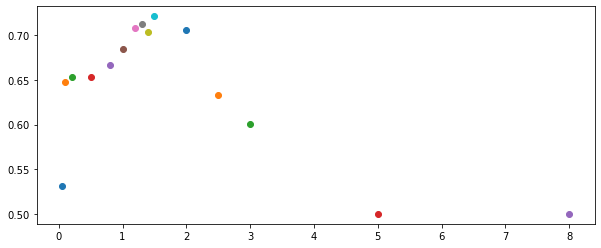

In [58]:
plt.figure(figsize = (10, 4))
roc_auc = []
for i in range(len(width)):
    roc_auc.append(roc_auc_score(Y_test, predicts[i]))
    plt.plot(width[i], roc_auc_score(Y_test, predicts[i]), 'o')

In [59]:
print(f'Максимальный показатель {np.max(np.array(roc_auc))} был достигнут с шириной окна {width[np.argmax(np.array(roc_auc))]}')

Максимальный показатель 0.7214109926168992 был достигнут с шириной окна 1.5


<h4>Настраиваю ширину окна и кол-во ближайших соседей по сетке</h4>

In [117]:
width = np.array(width)
neigh = sorted(np.random.randint(1, 600, 600))
grid = np.zeros((np.array(neigh).shape[0], width.shape[0]))

for i in range(0, len(neigh)):
    for j in range(0, width.shape[0]):
        model = KNeighborsClassifier(n_neighbors = neigh[i],
                                 weights = lambda x: K(x, h = width[j]))
        _ = model.fit(X_train, Y_train)
        grid[i][j] = roc_auc_score(Y_test, model.predict(X_test))
        #print(f'соседи: {neigh[i]}, ширина окна {width[j]}')

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  _ = model.fit(X_train, Y_train)
<ipython-input-117-ac1fe53c19c3>:9: DataConversionWarning: A column-vector y was passed when a 1

In [118]:
grid.max()

0.7598851517637407

In [123]:
print(neigh[3])
print(width[14])

5
8.0


Лучший результат для метода окна Парзена:
<ul>
    <li>Кол-во соседей: 5</li>
    <li>Ширина окна: 8</li>
    <li>Ядро: квадратичное</li>
    <li>ROC AUC: 0.76</li>
</ul>